In [ ]:
!pip install pmdarima

In [ ]:
!pip install workalendar
!pip install prophet
!pip install -q --upgrade linear-tree

In [2]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

In [3]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [4]:
df = pd.read_csv("Dataset (historic_demand_2009_2023).csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

In [5]:
df.sample(n=7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
112846,09-06-2015,28,33224,34427,30035,1166,3889,4020,8656,0,5,1495,0,994,-229,-469,0,NaN,NaN,0
191572,06-12-2019,5,23926,28045,22307,3456,6465,0,13080,0,1266,-1629,0,807,43,504,-624,0.0,0.0,0
52766,05-01-2012,15,39678,40291,36279,1556,1866,3,1144,0,13,1632,0,830,0,0,0,NaN,NaN,0
169960,11-09-2018,43,31990,32991,29781,2122,5911,0,13052,202,11,997,0,863,-414,-278,0,NaN,NaN,0
94962,01-06-2014,48,24339,25386,22080,522,3665,0,4782,0,19,1955,0,877,-134,-394,0,NaN,NaN,0
166913,10-07-2018,20,30961,31811,27520,810,5913,3950,13052,304,10,1996,0,1058,-397,-247,0,NaN,NaN,0
95093,04-06-2014,34,38509,39604,34941,696,3665,996,4799,0,14,1998,0,765,-152,-429,0,NaN,NaN,0


In [6]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
count,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,261792.000000,86496.000000,86496.000000,261792.000000
mean,24.500229,31521.005745,32928.194586,28678.613319,1225.719587,4306.073700,833.527445,8131.279783,7.098322,311.625466,911.095297,27.408584,525.030711,-115.495275,-34.507980,155.555953,290.905314,11.458946,0.022552
std,13.853823,7824.861423,7733.359243,7091.720116,929.470177,1940.528504,1643.248441,5648.807962,40.397146,536.671697,1083.274630,327.680300,524.570211,226.392822,254.808858,399.858970,573.178998,424.795982,0.148471
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,-2056.000000,-1030.000000,-1215.000000,-505.000000,-585.000000,-1022.000000,-1455.000000,-1028.000000,0.000000
25%,12.750000,25258.000000,26901.000000,22981.000000,533.000000,2087.000000,0.000000,1897.000000,0.000000,8.000000,206.000000,0.000000,0.000000,-268.000000,-159.000000,0.000000,0.000000,0.000000,0.000000
50%,24.500000,30900.000000,32127.000000,28107.000000,984.000000,4260.000000,0.000000,10500.000000,0.000000,11.000000,1186.000000,0.000000,754.000000,-132.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,36.250000,37275.000000,38433.000000,33936.000000,1666.000000,6465.000000,799.000000,13080.000000,0.000000,398.000000,1893.000000,0.000000,994.000000,37.000000,0.000000,14.000000,693.000000,0.000000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5354.000000,6574.000000,9830.000000,15954.000000,893.000000,2019.000000,2066.000000,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,1.000000


In [7]:
df.shape

(261792, 20)

In [8]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

In [9]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
is_holiday                   False
dtype: bool

In [10]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

,nsl_flow,eleclink_flow
True,175296,175296
False,86496,86496


In [11]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]


,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,01-01-2009,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,01-01-2009,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,01-01-2009,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,01-01-2009,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,01-01-2009,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261595,31-12-2018,44,26826,28428,25195,2734,5918,0,13052,0,13,1960,0,777,-454,-535,0,NaN,NaN,0
261596,31-12-2018,45,25660,27542,24145,2730,5918,0,13052,0,23,1182,0,-268,-455,-536,0,NaN,NaN,0
261597,31-12-2018,46,25047,26971,23496,2726,5918,0,13052,0,36,1157,0,-297,-455,-536,0,NaN,NaN,0
261598,31-12-2018,47,24188,26224,22683,2673,5918,0,13052,0,49,1546,0,-467,-454,-466,0,NaN,NaN,0


In [12]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

In [13]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [14]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

In [15]:
# Convert to Pandas Timestamp objects
holiday_dates_observed = [pd.Timestamp(x) for x in holiday_dates_observed]

# Extract date part in dd-mm-yyyy format
holiday_dates_observed = [date.strftime('%d-%m-%Y') for date in holiday_dates_observed]


In [16]:
holiday_dates_observed[:5]

['01-01-2009', '10-04-2009', '13-04-2009', '04-05-2009', '25-05-2009']

In [17]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: x in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 0].sample(7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
222322,26-10-2023,43,30490,31835,28157,1619,6488,0,15954,0,13,1506,939,-3,-451,-378,482,0
10173,02-03-2010,46,37904,40051,33800,524,1829,0,0,0,525,-603,0,0,-419,0,0,0
216453,26-02-2021,26,30455,31060,27639,854,6527,6780,13080,0,5,2002,992,1061,191,0,999,0
192586,23-05-2016,11,20502,22471,18421,585,4260,64,10500,0,1469,1396,0,491,197,285,0,0
99925,12-08-2009,38,38056,38842,34889,517,1755,0,0,0,5,1993,0,0,-281,0,0,0
13845,02-08-2012,22,37247,38005,33867,294,2085,618,1821,0,9,1995,0,953,-249,0,0,0
52725,07-02-2012,22,49416,53273,44945,151,1950,137,1315,0,8,-2041,0,-999,-209,0,0,0


In [18]:
df['settlement_date'] = pd.to_datetime(df['settlement_date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')


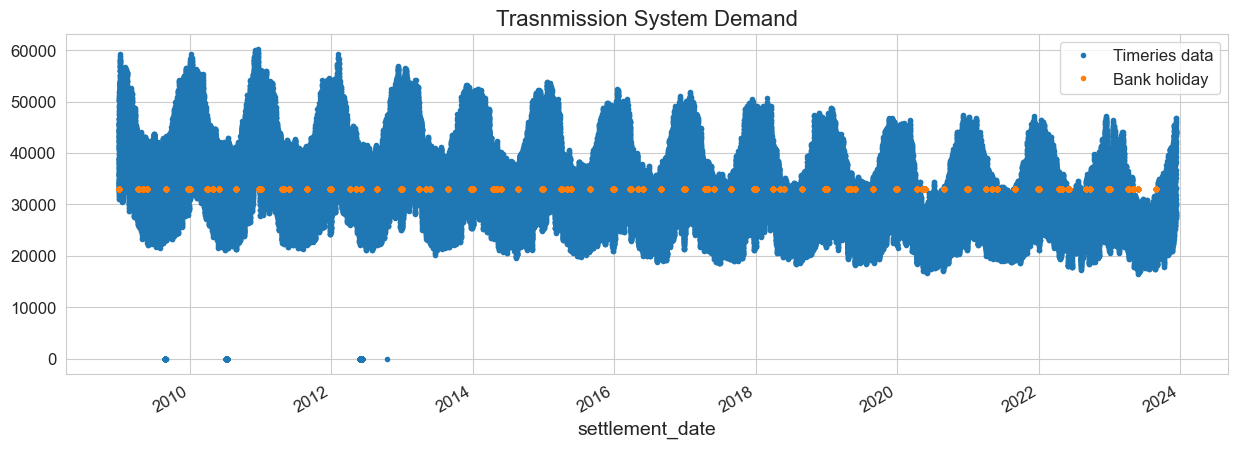

In [19]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

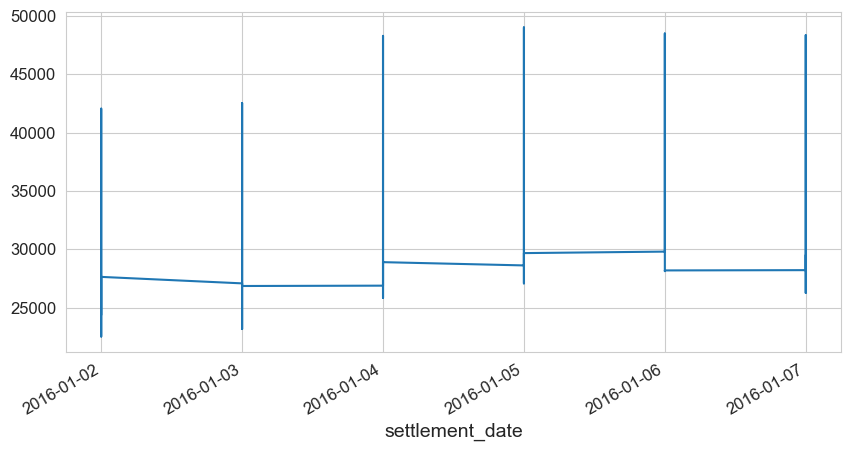

In [20]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

In [21]:
df_plot.head()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,
2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


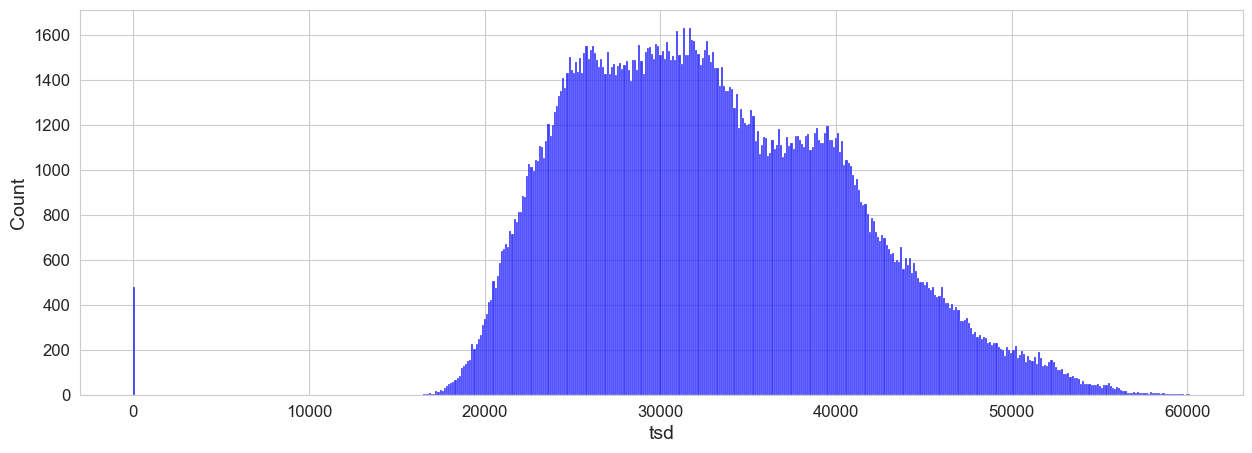

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

In [23]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [24]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
41481,2022-10-05,10,4:30:00,16141,21464,15384,3157,6545,0,13861,0,581,0,-1029,-758,-16,-34,-1020,0
207878,2016-03-25,41,20:00:00,34747,35535,32014,2070,4210,0,9300,0,14,1997,0,985,-174,61,0,1
236713,2020-07-28,44,21:30:00,24893,26123,23310,1968,6527,0,13080,0,7,-632,0,904,-77,-14,894,0
75289,2023-09-09,26,12:30:00,21190,22672,19413,711,6538,8143,15872,0,5,493,991,1061,-451,-526,999,0
54496,2023-04-07,17,8:00:00,25205,26564,22358,511,6545,2633,15340,0,11,139,387,854,-206,-112,-392,1
104382,2020-02-13,31,15:00:00,37769,38487,34349,2232,6465,1780,13080,0,7,2003,0,856,-45,-66,1000,0
12804,2022-06-02,37,18:00:00,25200,30079,22591,623,6545,2444,13859,0,5,-935,-1028,-713,-255,-248,-362,1


In [25]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
234492,2019-04-28 15:00:00,31,15:00:00,27347,27853,24538,874,6122,4140,13080,0,6,946,0,951,124,413,830,0
165790,2019-04-20 23:00:00,47,23:00:00,24123,24770,21565,438,6122,0,13080,0,14,682,0,690,-133,0,395,0
11832,2016-05-02 12:00:00,25,12:00:00,29273,29782,26736,2736,4260,2950,9602,0,9,1995,0,1000,69,134,0,1
181030,2009-02-22 11:00:00,23,11:00:00,37904,38610,34296,902,1405,0,0,0,4,1383,0,0,-102,0,0,0
182324,2021-03-22 10:00:00,21,10:00:00,33271,34492,30556,1077,6527,4630,13080,0,9,1316,374,0,-450,-162,705,0


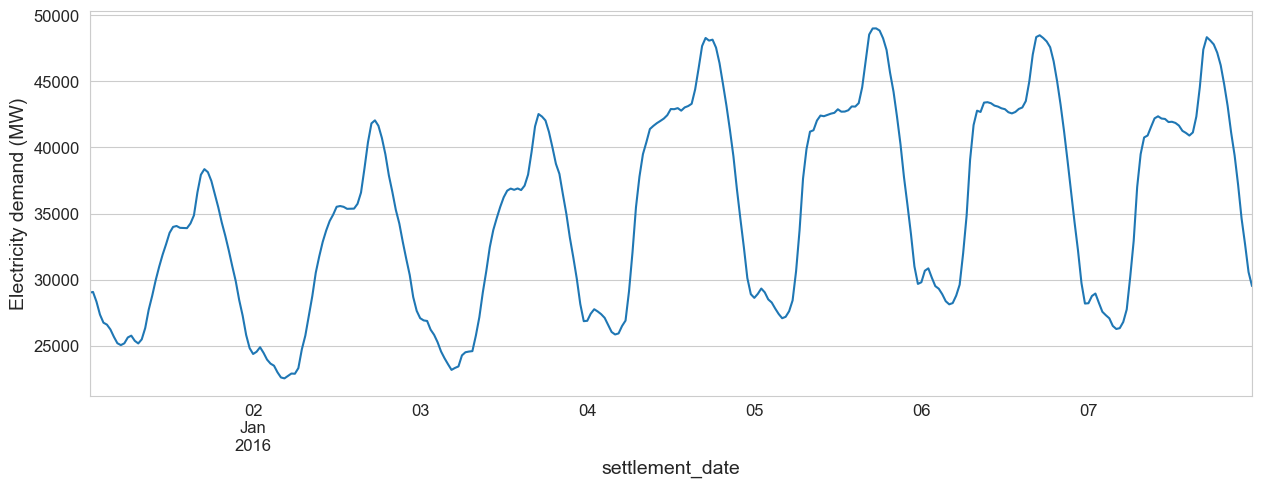

In [26]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [27]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [28]:
df

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07 21:30:00,44,21:30:00,32467,33192,30107,2876,6488,0,15595,0,12,734,-4,229,-55,0,222,0
2023-12-07 22:00:00,45,22:00:00,30767,31746,28450,2746,6488,0,15595,0,11,-217,-4,375,67,0,566,0
2023-12-07 22:30:00,46,22:30:00,29315,30335,27039,2616,6488,0,15595,0,12,-276,-4,380,54,0,577,0


In [29]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_month,day_of_week,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,,,,,,,,,,,,,
2009-12-15 20:30:00,42,20:30:00,48789,51883,44284,325,1773,0,0,0,...,15,1,349,4,12,2009,51,NaN,NaN,NaN
2022-01-03 15:00:00,31,15:00:00,31905,32762,28946,2479,6527,195,13670,0,...,3,0,3,1,1,2022,1,42810.0,38984.0,40251.0
2021-07-23 04:30:00,10,4:30:00,20678,22808,18766,484,6527,0,13080,0,...,23,4,204,3,7,2021,29,20968.0,23554.0,23645.0
2023-09-23 10:30:00,22,10:30:00,21894,22942,19256,525,6538,6392,15910,0,...,23,5,266,3,9,2023,38,26317.0,29030.0,25521.0
2015-11-10 13:00:00,27,13:00:00,37342,38458,34114,2684,4013,723,8992,0,...,10,1,314,4,11,2015,46,41737.0,42235.0,42722.0


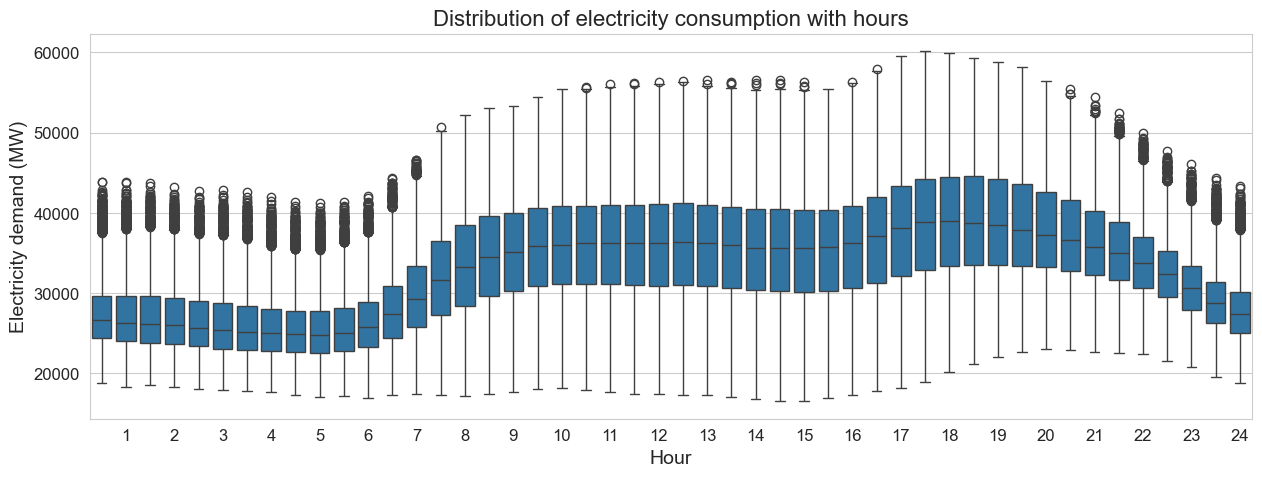

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

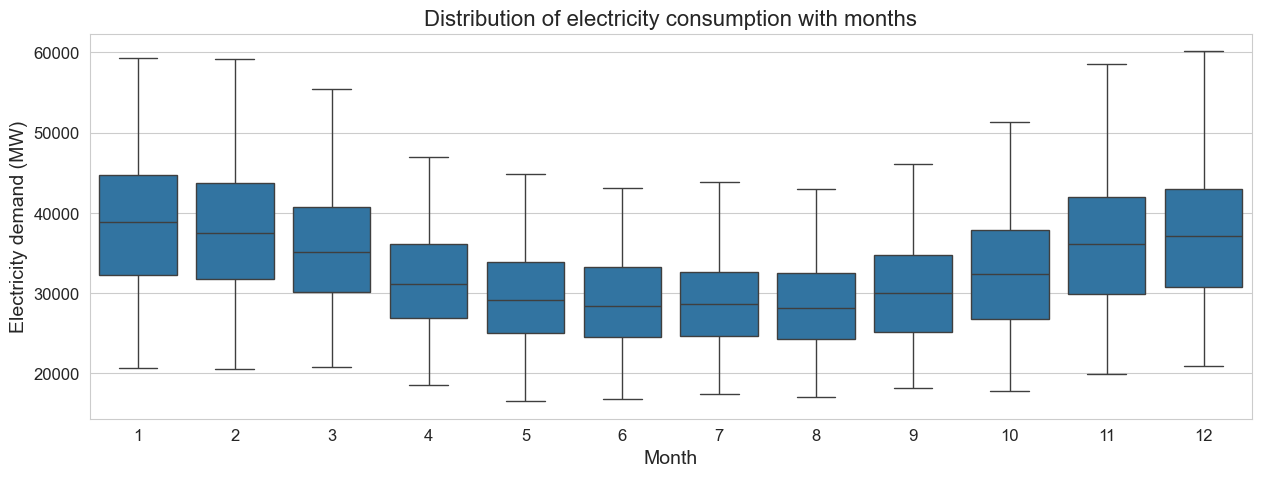

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

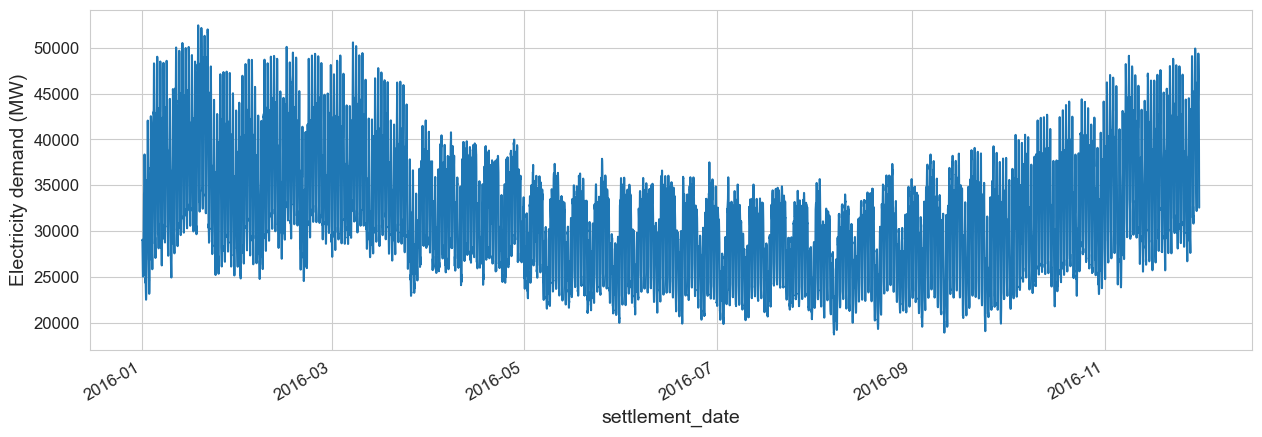

In [32]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

It seems that from Mondat to Friday, the electricity consumption is on average lower on bank holidays, whereas it is higher on Saturday and it's the same on Sundays.

For non bank holiday, the demand on the weekend is lower than during week days.

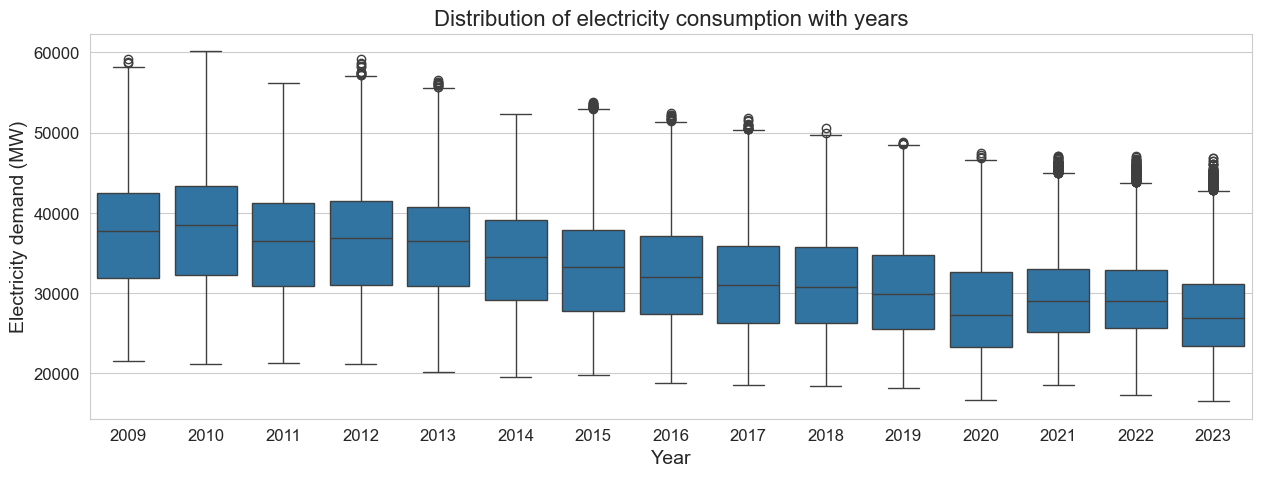

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

Although these are yearly average values, one can see a decreasing trend in the electricity consumption. We can overlay the electricity consumption of two years to see how they compare:

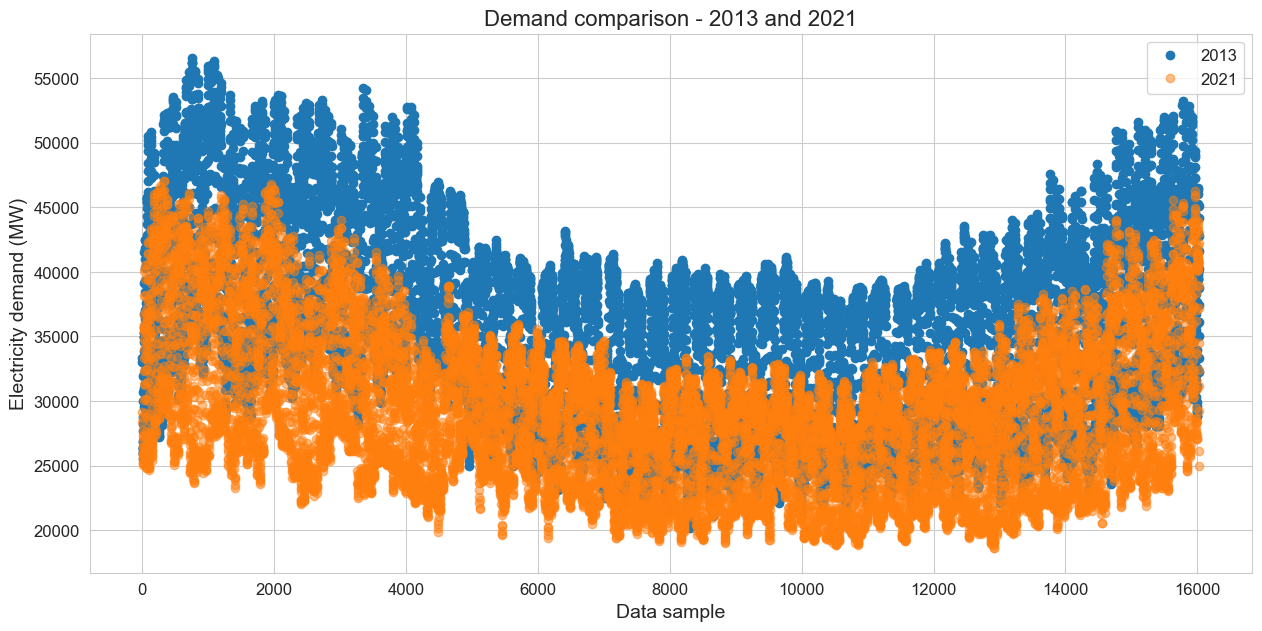

In [35]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)


ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

Again, this plot confirms that electricity consumption is decreasing in recent years.

In [36]:
df.columns

Index(['settlement_period', 'period_hour', 'nd', 'tsd', 'england_wales_demand',
       'embedded_wind_generation', 'embedded_wind_capacity',
       'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor',
       'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow',
       'moyle_flow', 'east_west_flow', 'nemo_flow', 'is_holiday',
       'day_of_month', 'day_of_week', 'day_of_year', 'quarter', 'month',
       'year', 'week_of_year', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [37]:
# List of features to remove
features_to_remove = ['day_of_month', 'day_of_week', 'day_of_year', 'quarter', 'month',
                      'year', 'week_of_year', 'is_holiday', 'settlement_period', 'period_hour']

# Remove the specified features
df_reduced = df.drop(columns=features_to_remove)

# Calculate correlation matrix
correlation_matrix_reduced = df_reduced.corr()

# Get correlation with the target variable
correlation_with_tsd_reduced = correlation_matrix_reduced['tsd'].abs().sort_values(ascending=False)

# Print correlation with the target variable
print("Correlation with 'tsd' after removing time-related and categorical features:")
print(correlation_with_tsd_reduced)


Correlation with 'tsd' after removing time-related and categorical features:
tsd                          1.000000
nd                           0.992173
england_wales_demand         0.990967
lag1                         0.932825
lag2                         0.926531
lag3                         0.923951
embedded_solar_capacity      0.432822
embedded_wind_capacity       0.430386
pump_storage_pumping         0.427412
moyle_flow                   0.334498
east_west_flow               0.232051
embedded_solar_generation    0.160860
embedded_wind_generation     0.141186
nemo_flow                    0.139156
ifa_flow                     0.135383
non_bm_stor                  0.133189
ifa2_flow                    0.048404
britned_flow                 0.009187
Name: tsd, dtype: float64


In [38]:
# Select features with correlation coefficient above a certain threshold
threshold = 0.4  # Adjust threshold as needed
selected_features_reduced = correlation_with_tsd_reduced[correlation_with_tsd_reduced > threshold].index.tolist()

print("Selected Features based on correlation coefficient above threshold:")
print(selected_features_reduced)


Selected Features based on correlation coefficient above threshold:
['tsd', 'nd', 'england_wales_demand', 'lag1', 'lag2', 'lag3', 'embedded_solar_capacity', 'embedded_wind_capacity', 'pump_storage_pumping']


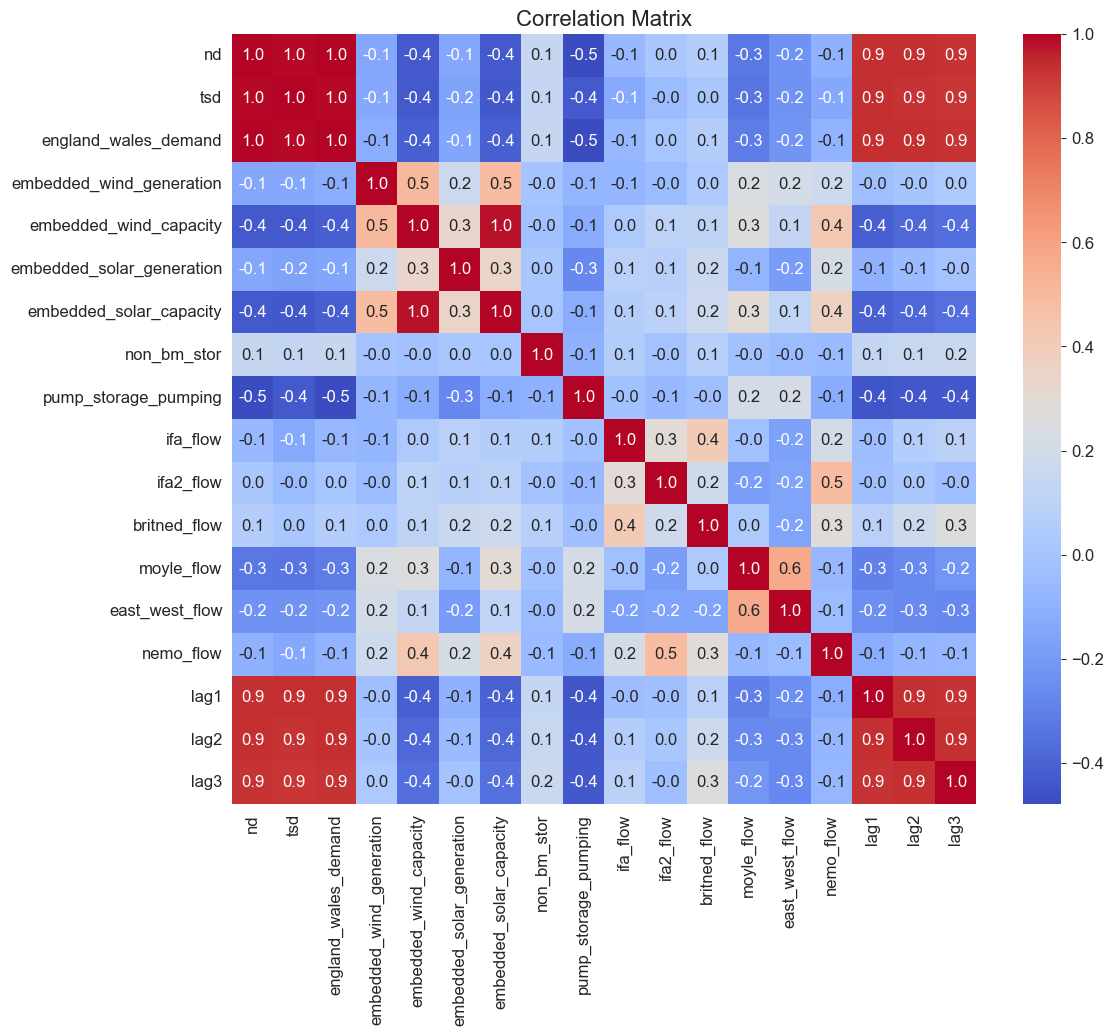

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the heatmap
plt.figure(figsize=(12, 10))

# Plot correlation matrix
sns.heatmap(correlation_matrix_reduced, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Correlation Matrix')
plt.show()


In [46]:
import xgboost as xgb

threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

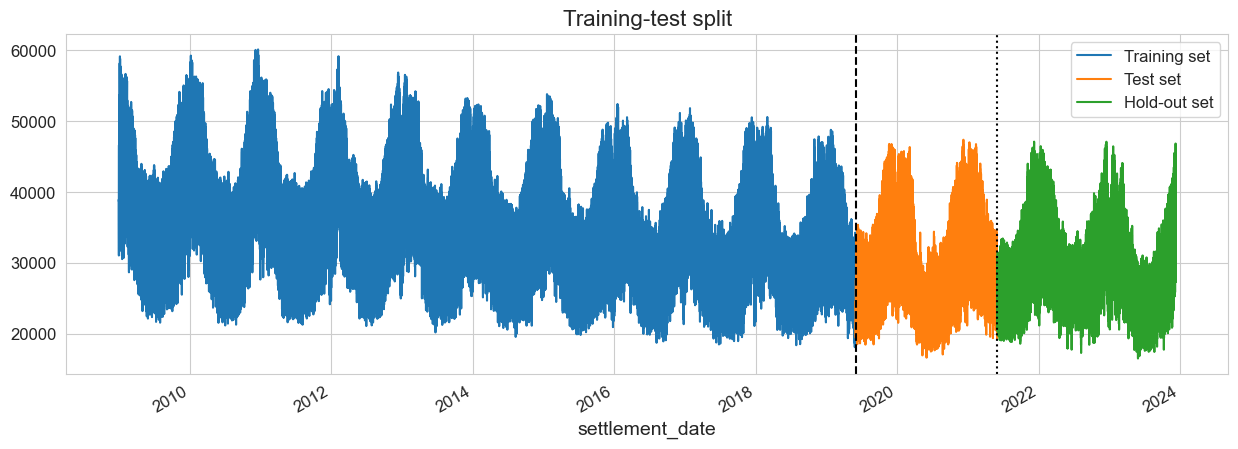

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [48]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

In [51]:
X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500, 
    max_depth=3, 
    learning_rate=0.01, 
    early_stopping_rounds=50, 
#     tree_method="gpu_hist",
    random_state=43, 
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);

[0]	validation_0-rmse:7537.22500	validation_1-rmse:8202.98096
[100]	validation_0-rmse:4933.76548	validation_1-rmse:6269.31058
[200]	validation_0-rmse:3758.00700	validation_1-rmse:5207.33174
[300]	validation_0-rmse:3098.69455	validation_1-rmse:4566.22419
[400]	validation_0-rmse:2694.51449	validation_1-rmse:4174.74550
[499]	validation_0-rmse:2442.15493	validation_1-rmse:3929.78877


#### Feature importance
Since there are multiple parameters, we can check the importance of each of them as follows:

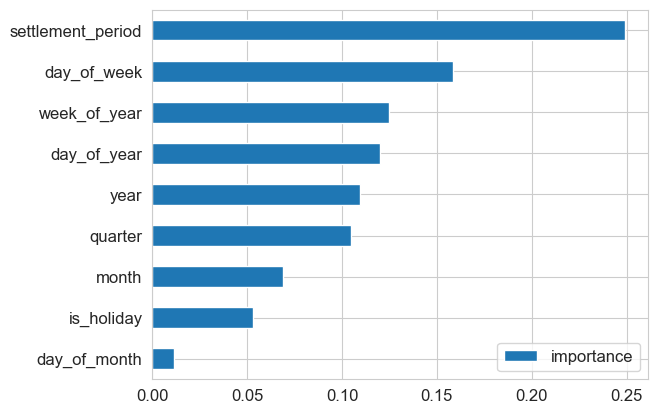

In [52]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh");

In [53]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)


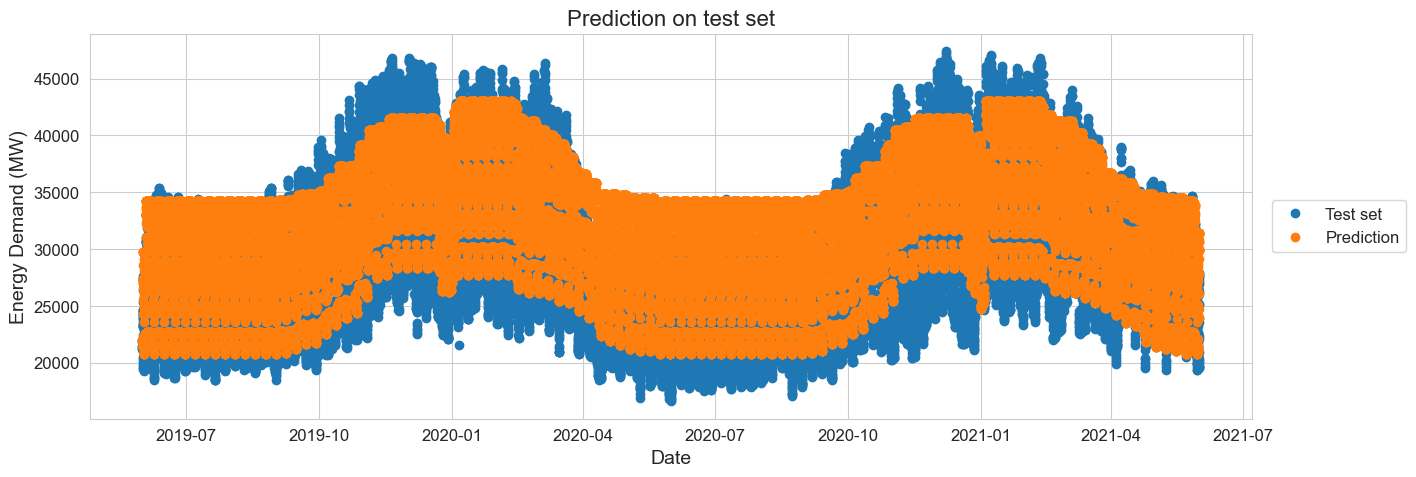

In [54]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

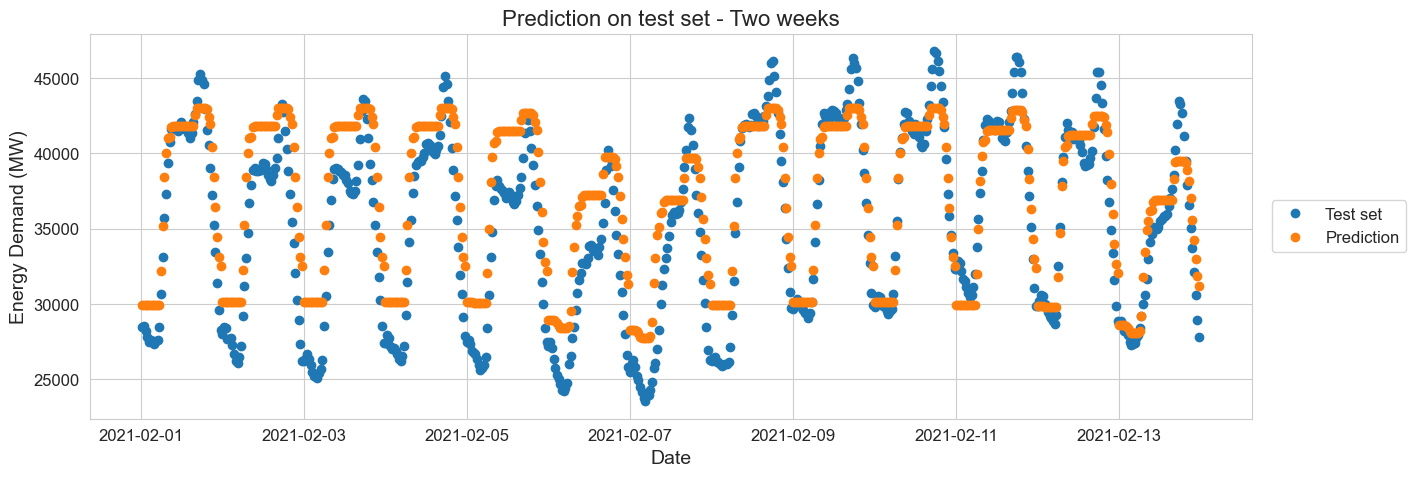

In [55]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape




mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 11.29


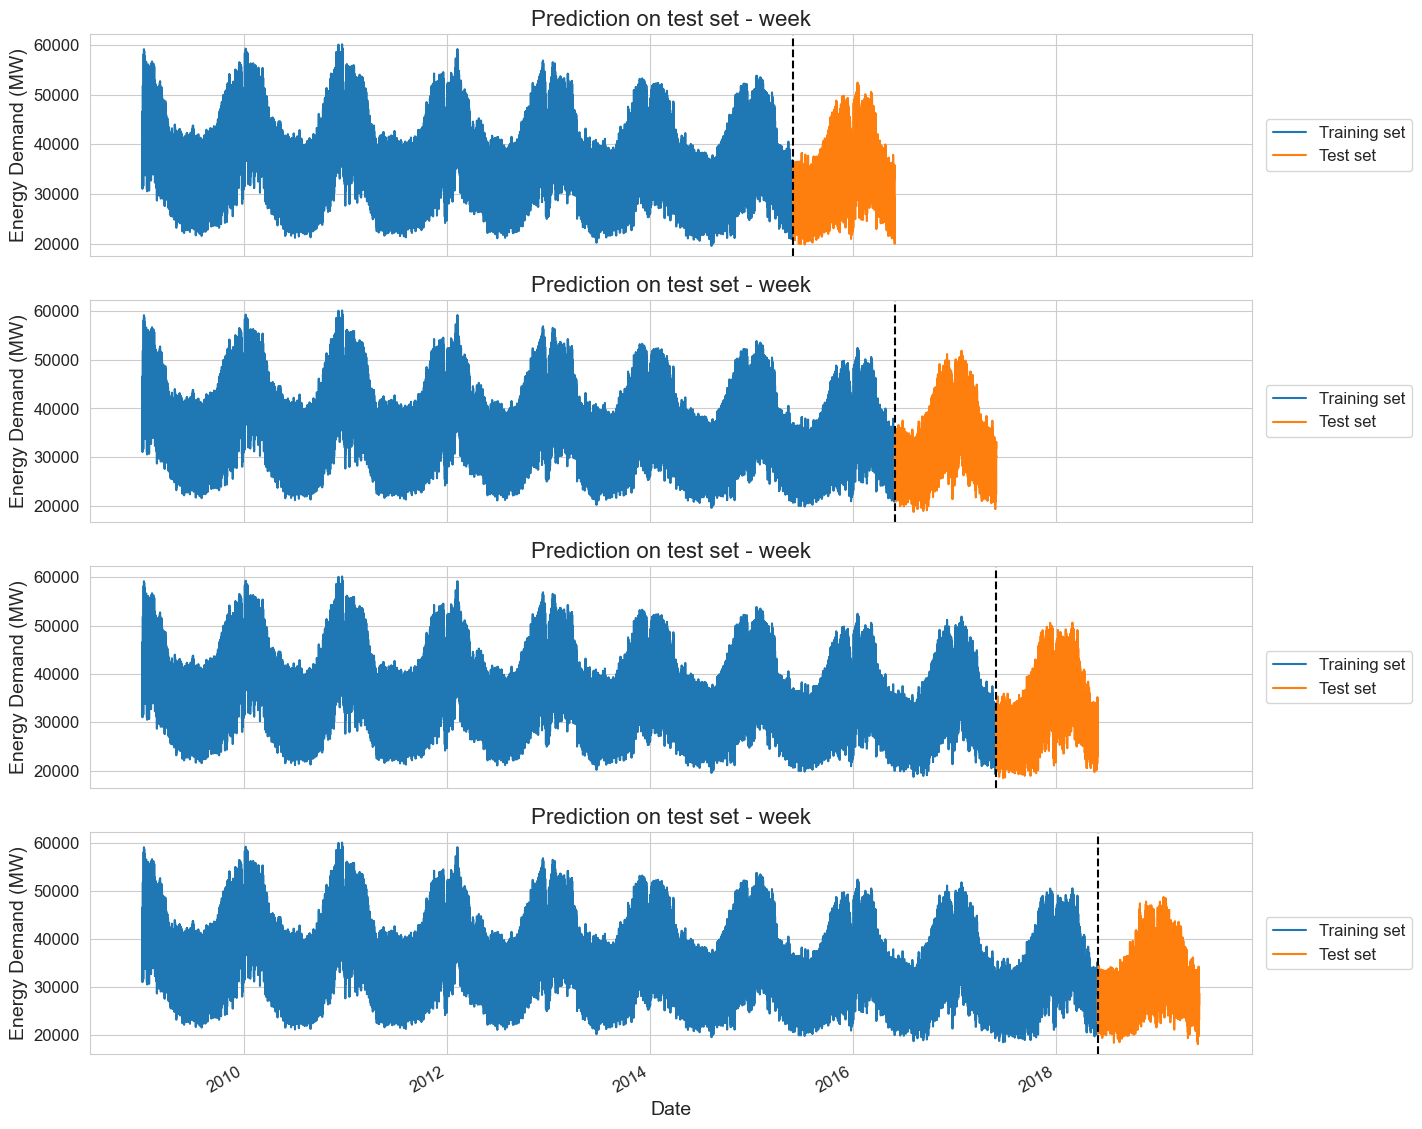

In [59]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [60]:
import warnings

def fxn():
    warnings.warn("FutureWarning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [63]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Assuming you have imported train_data, test_data, hold_out_data, and tss

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test, and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]

# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "rmse",
    "eval_set": [[X_hold_out, y_hold_out]],
}

# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    learning_rate=0.01,
    tree_method="hist",  # Use 'hist' method instead of 'gpu_hist'
    random_state=43,
)

# Define parameters for the optimizer
param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}

# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

# Fit the model
xgb_search.fit(X_train_cv, y_train_cv, verbose=500, **fit_params)


Fitting 4 folds for each of 18 candidates, totalling 72 fits
[0]	validation_0-rmse:28981.67512
[349]	validation_0-rmse:2493.33928
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2036.694 total time=   1.7s
[0]	validation_0-rmse:28983.42934
[349]	validation_0-rmse:2551.55967
[CV 2/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2570.231 total time=   1.8s
[0]	validation_0-rmse:28984.56357
[349]	validation_0-rmse:2557.03538
[CV 3/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2782.514 total time=   2.1s
[0]	validation_0-rmse:28986.88796
[349]	validation_0-rmse:2521.91871
[CV 4/4] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2330.748 total time=   2.2s
[0]	validation_0-rmse:28981.79047
[349]	validation_0-rmse:2495.14057
[CV 1/4] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2038.604 total time=   1.7s
[0]	validation_0-rmse:28983.46832
[349]	validation_0-rmse:2555.14987
[CV 2/4] END max_depth=3, n_estimators=350, su

GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=4, test_size=17520),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=Non...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=43, ...),
             param_grid={'max_depth': [3, 5], 'n_estimators': [350, 500, 650],
                         'subsample': [0.95, 0.8, 0.7]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [64]:
xgb_search.best_params_

{'max_depth': 5, 'n_estimators': 650, 'subsample': 0.7}

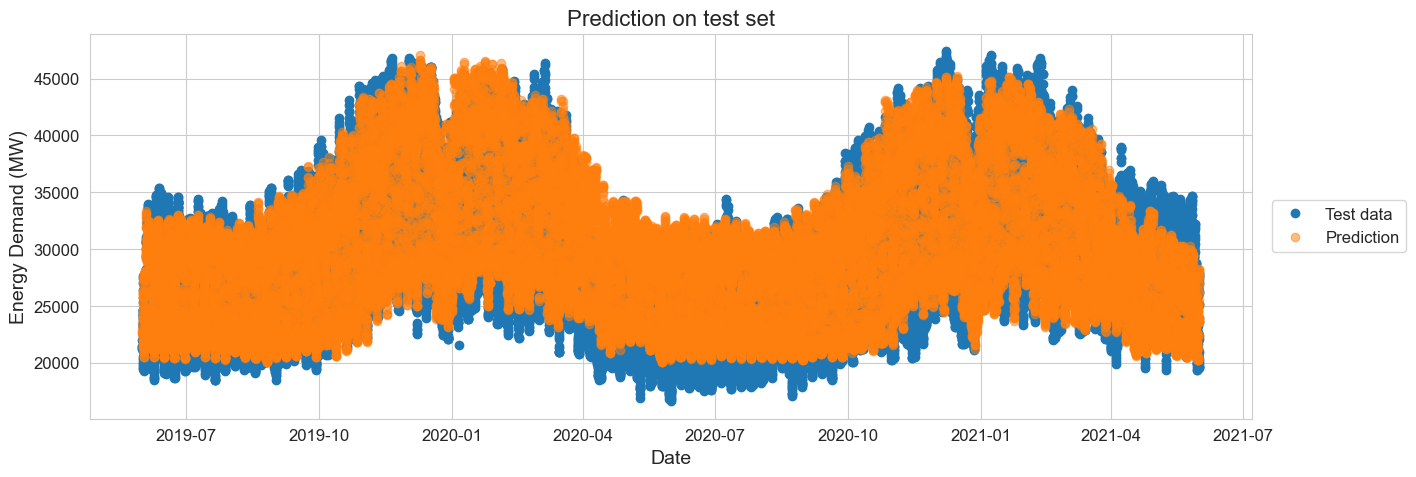

In [65]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

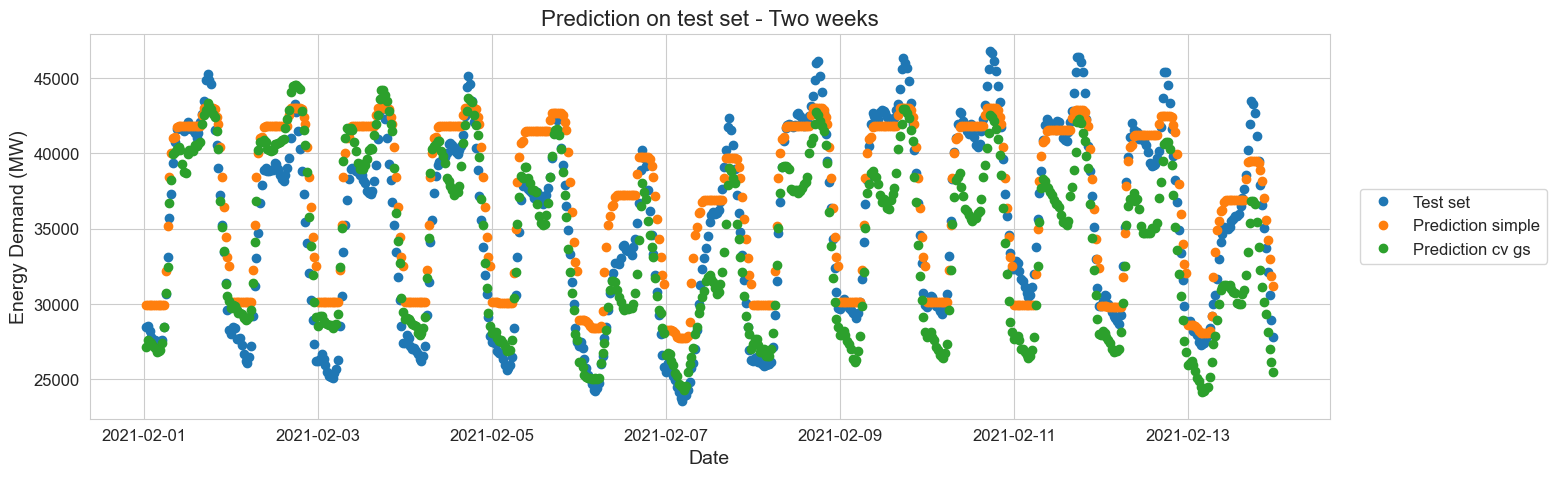

In [66]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [67]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.39
Root Mean Squared Error of the cross-validated model is: 2679.36 MW


In [68]:
X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)
xgb_best.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=100,
    early_stopping_rounds=50,
);

[0]	validation_0-rmse:33520.99353
[100]	validation_0-rmse:12513.87288
[200]	validation_0-rmse:5085.88118
[300]	validation_0-rmse:2749.25600
[400]	validation_0-rmse:2128.61487
[500]	validation_0-rmse:1933.72879
[600]	validation_0-rmse:1849.46202
[649]	validation_0-rmse:1822.47213


In [69]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["settlement_period"] = settlement_period_array

    return df

In [70]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

df_and_future_wprediction.tail()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,day_of_year,quarter,month,year,week_of_year,lag1,lag2,lag3,is_future,settlement_date
2024-07-04 21:30:00,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,186,3,7,2024,27,26412.0,29516.0,29929.0,True,2024-07-04
2024-07-04 22:00:00,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,186,3,7,2024,27,25877.0,29170.0,29412.0,True,2024-07-04
2024-07-04 22:30:00,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,186,3,7,2024,27,24666.0,28013.0,28072.0,True,2024-07-04
2024-07-04 23:00:00,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,186,3,7,2024,27,23066.0,27610.0,26091.0,True,2024-07-04
2024-07-04 23:30:00,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,186,3,7,2024,27,21865.0,26711.0,24790.0,True,2024-07-04


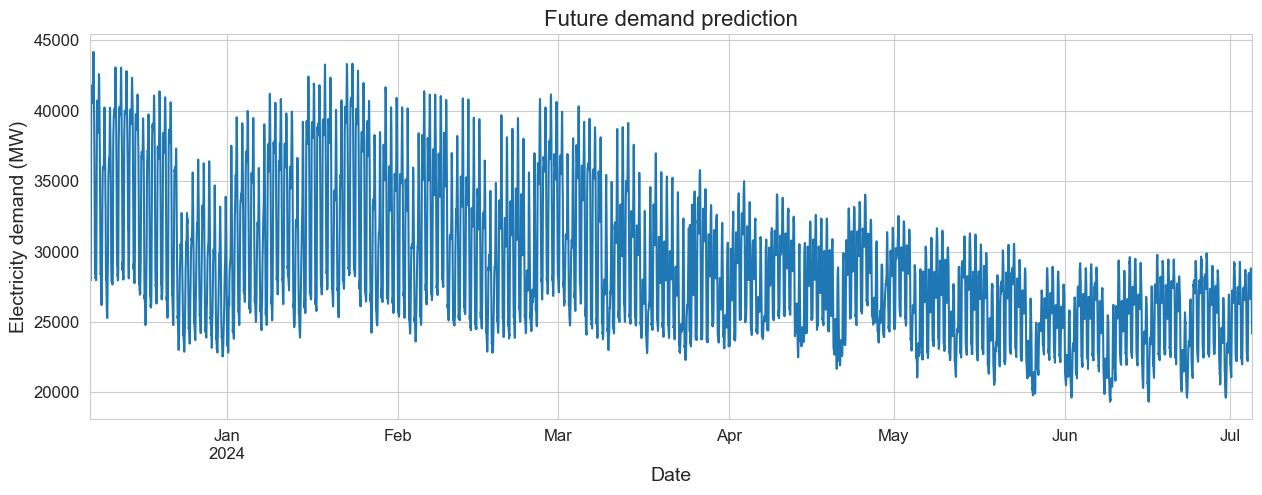

In [71]:
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(
    df_and_future_wprediction[FEATURES_CV]
)


fig, ax = plt.subplots(figsize=(15, 5))
df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

In [72]:
%%time
linear_boost = LinearBoostRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    n_estimators = 350, 
    max_depth = 6,
    random_state = 43,
)

linear_boost.fit(X_train, y_train)

result_frame["pred_linear_boost"] = linear_boost.predict(X_test)

CPU times: total: 38min 38s
Wall time: 7min 49s


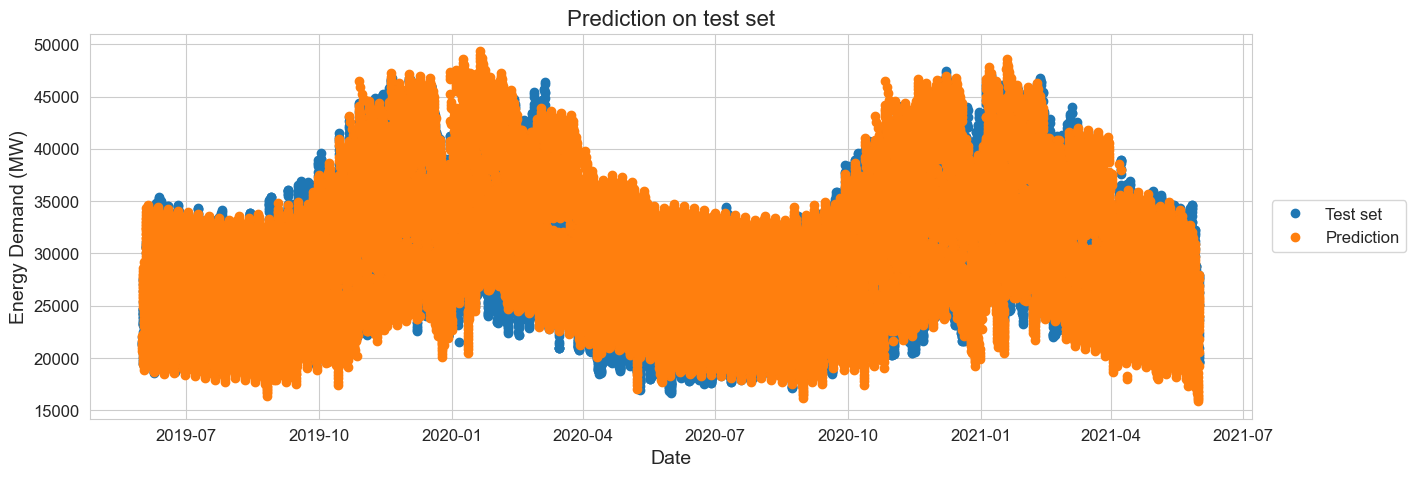

In [73]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_linear_boost"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

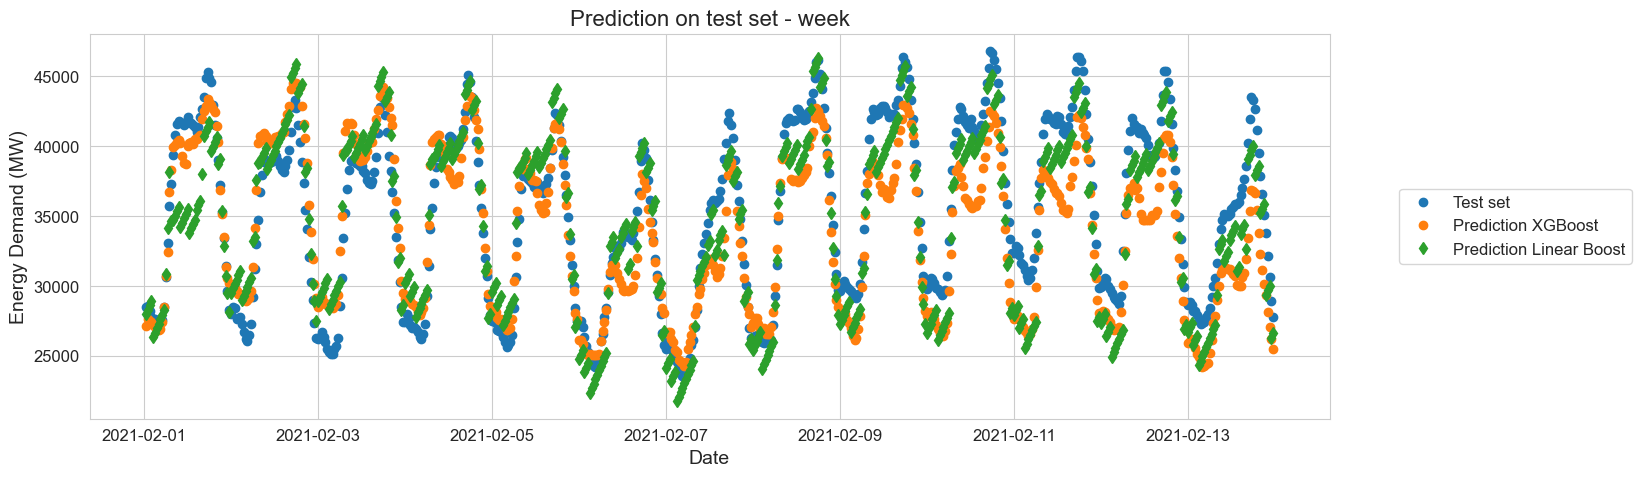

In [74]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction XGBoost",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_linear_boost"
    ],
    "d",
    label="Prediction Linear Boost",
)

ax.legend(loc="center", bbox_to_anchor=(1.15, 0.5))

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [75]:
mape_linear_boost = mean_absolute_percentage_error(
    y_test, result_frame["pred_linear_boost"]
)
rmse_linear_boost = np.sqrt(mean_squared_error(y_test, result_frame["pred_linear_boost"]))

print(
    "Mean Absolute Percentage Error of the Linear Boosted model is: %.2f"
    % mape_linear_boost
) 
print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_linear_boost
)

Mean Absolute Percentage Error of the Linear Boosted model is: 8.20
Root Mean Squared Error of the simple models is: 2963.07 MW


In [76]:
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [77]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(FEATURES))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_keras_s[:,-1]

In [93]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout

In [100]:
# Define a random seed for reproducibility
tf.random.set_seed(221)

# Create and compite neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)

reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, reduce_lr_loss]
)

Epoch 1/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1544 - val_loss: 0.0960 - learning_rate: 0.0010
Epoch 2/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1074 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 3/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0977 - val_loss: 0.0874 - learning_rate: 0.0010
Epoch 4/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0933 - val_loss: 0.0850 - learning_rate: 0.0010
Epoch 5/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0896 - val_loss: 0.0840 - learning_rate: 0.0010
Epoch 6/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0869 - val_loss: 0.0819 - learning_rate: 0.0010
Epoch 7/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0853 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 8/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0842 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 9/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0829 - val_loss: 0.0800 - lear

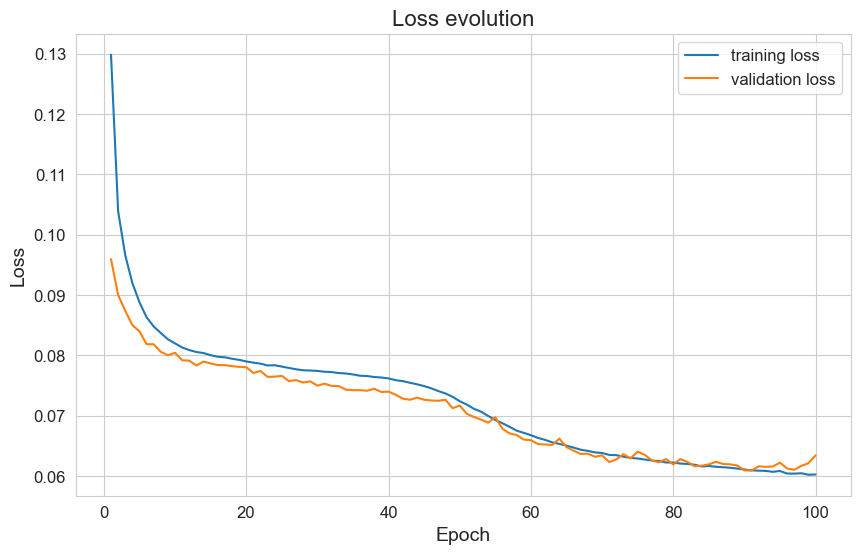

In [101]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

In [102]:
# Prediction on test set
pred_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_lstm"] = results_lstm[:,-1]

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


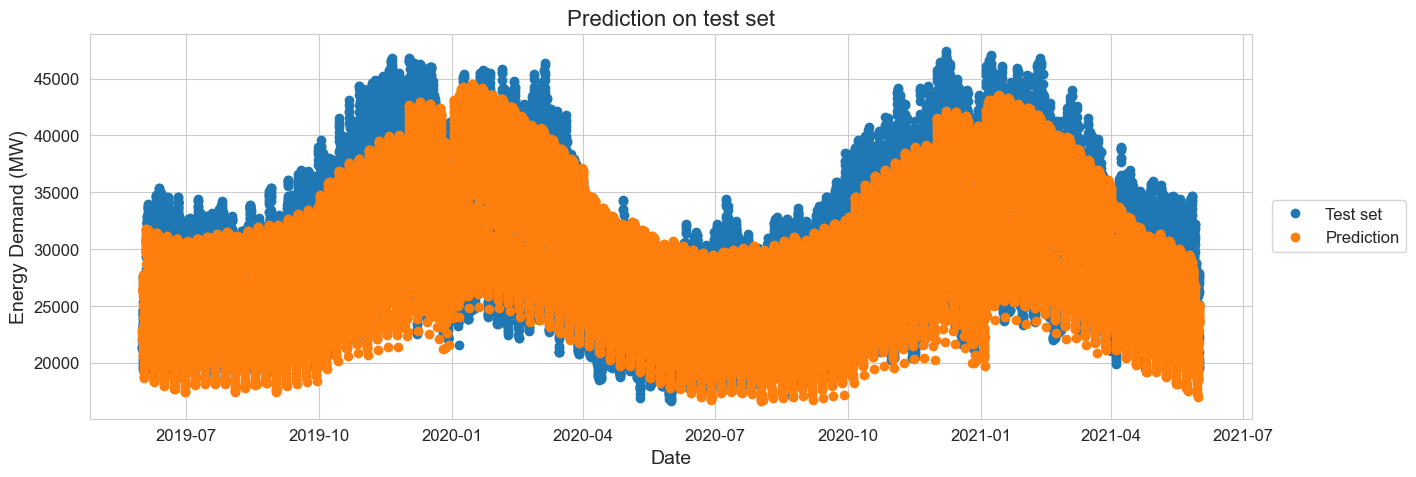

In [103]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

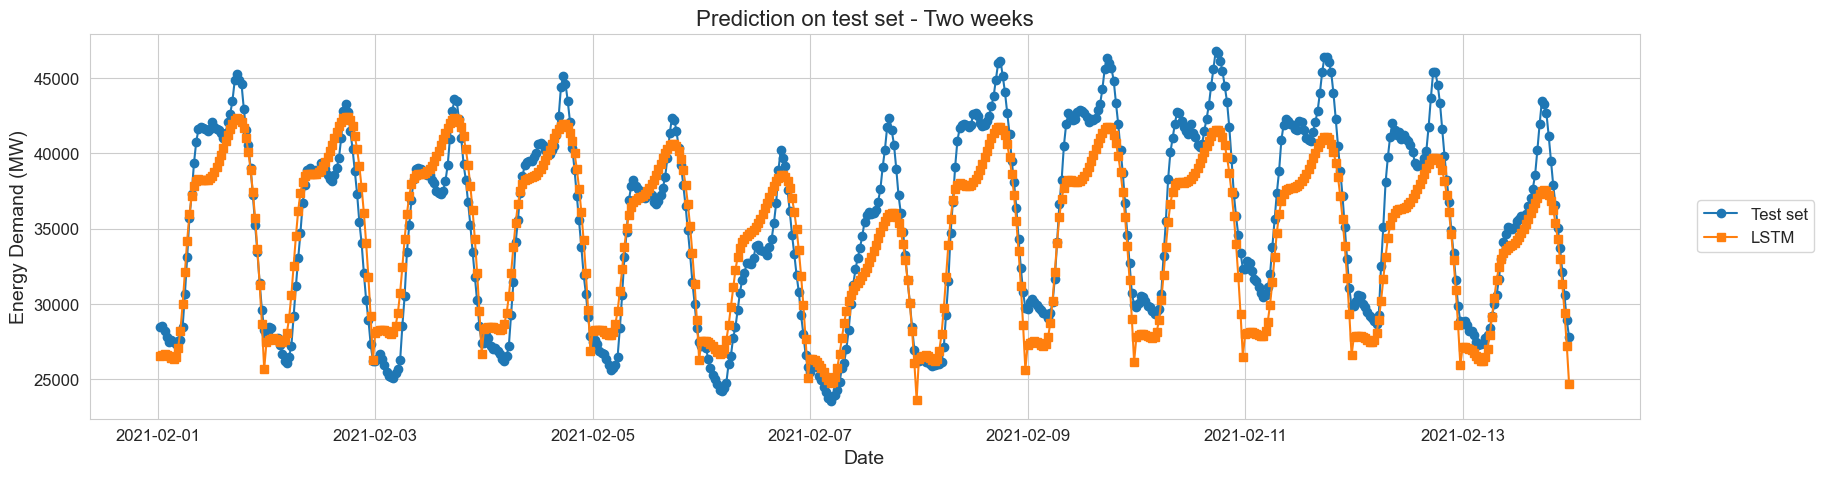

In [104]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [105]:
mape_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_lstm"]
)

rmse_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_lstm"]))

print(
    "Mean Absolute Percentage Error of the LSTM model is: %.2f" % mape_lstm
)

print(
    "Root Mean Squared Error of the LSTM model is: %.2f MW" % rmse_lstm
)

Mean Absolute Percentage Error of the LSTM model is: 7.71
Root Mean Squared Error of the LSTM model is: 2831.73 MW


In [106]:
# Create and compile neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history_deep_lstm = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, reduce_lr_loss]
)

Epoch 1/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.1701 - val_loss: 0.0782 - learning_rate: 0.0010
Epoch 2/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0980 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 3/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0879 - val_loss: 0.0455 - learning_rate: 0.0010
Epoch 4/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0802 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 5/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0745 - val_loss: 0.0342 - learning_rate: 0.0010
Epoch 6/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0722 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 7/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0704 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 8/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0700 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 9/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0689 - val_loss: 0.032

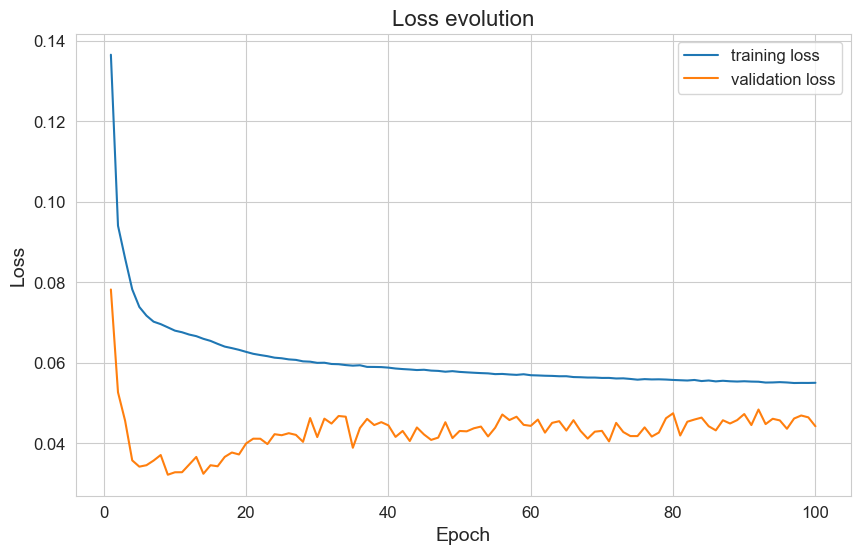

In [107]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

In [108]:
# Prediction on test set
pred_deep_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_deep_lstm"] = results_deep_lstm[:,-1]

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


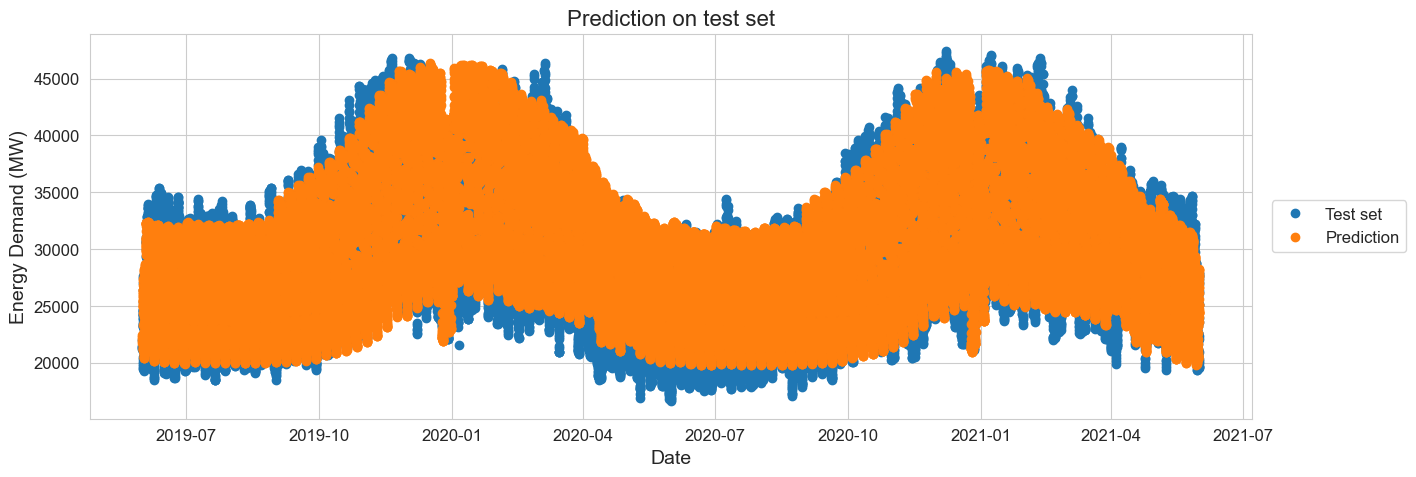

In [109]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_deep_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

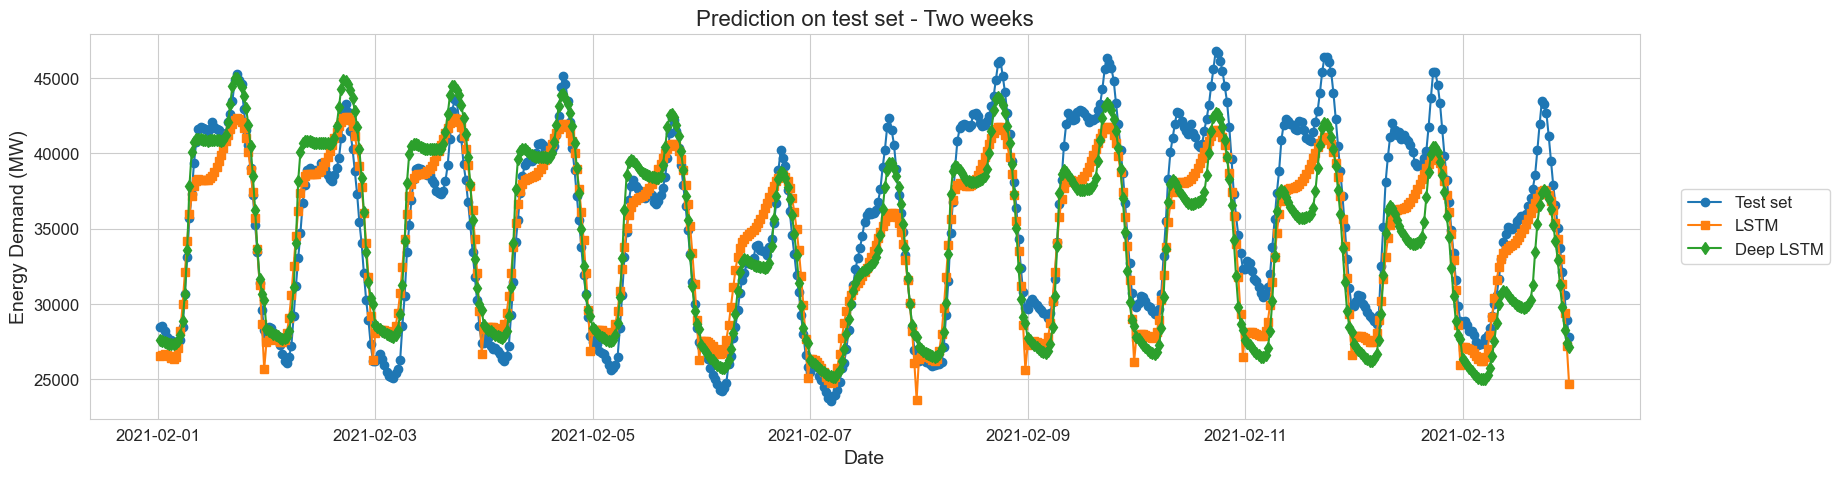

In [110]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_deep_lstm"
    ],
    "-d",
    label="Deep LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [111]:
mape_deep_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_deep_lstm"]
)

rmse_deep_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_deep_lstm"]))

print(
    "Mean Absolute Percentage Error of the deep LSTM model is: %.2f" % mape_deep_lstm
)

print(
    "Root Mean Squared Error of the deep LSTM model is: %.2f MW" % rmse_deep_lstm
)

Mean Absolute Percentage Error of the deep LSTM model is: 7.38
Root Mean Squared Error of the deep LSTM model is: 2685.79 MW


In [112]:
summary_df = pd.DataFrame(
    {
        "XGBoost - Simple": [mape_xgboost_simple, rmse_xgboost_simple],
        "XGBoost - CV & GS": [mape_xgboost_cv, rmse_xgboost_cv],
        "Linear Boost": [mape_linear_boost, rmse_linear_boost],
        "LSTM": [mape_lstm, rmse_lstm],
        "Deep LSTM": [mape_deep_lstm, rmse_deep_lstm],
        "Metric": ["MAPE", "RMSE"]
    }
)

summary_df.set_index("Metric", inplace=True)

summary_df.style.format('{:.2f}') 

,XGBoost - Simple,XGBoost - CV & GS,Linear Boost,LSTM,Deep LSTM
Metric,,,,,
MAPE,11.29,7.39,8.20,7.71,7.38
RMSE,3786.88,2679.36,2963.07,2831.73,2685.79
